# Beamforming ABLE DNN Aided Algorithm

## Import Libraries

In [ ]:
import torch
import numpy as np
import scipy as sc
import scipy.signal
import matplotlib.pyplot as plt
import random
import h5py
import torch.nn as nn
import warnings
import time
import copy
import torch.optim as optim
from datetime import datetime
from itertools import permutations
from torch.autograd import Variable
from tqdm import tqdm
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
warnings.simplefilter("ignore")
plt.close('all')
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

### Device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Set Similar Seed

In [ ]:
def Set_Overall_Seed(SeedNumber = 42):
  random.seed(SeedNumber)
  np.random.seed(SeedNumber)
  torch.manual_seed(SeedNumber)
Set_Overall_Seed()

## Pathing

In [ ]:
saving_path = r"C:\Users\dorsh\OneDrive\שולחן העבודה\Final Project\python notebooks\Weights"
Data_saving_path = r"C:\Users\dorsh\OneDrive\שולחן העבודה\Final Project\python notebooks\DataSet\TrainingData"


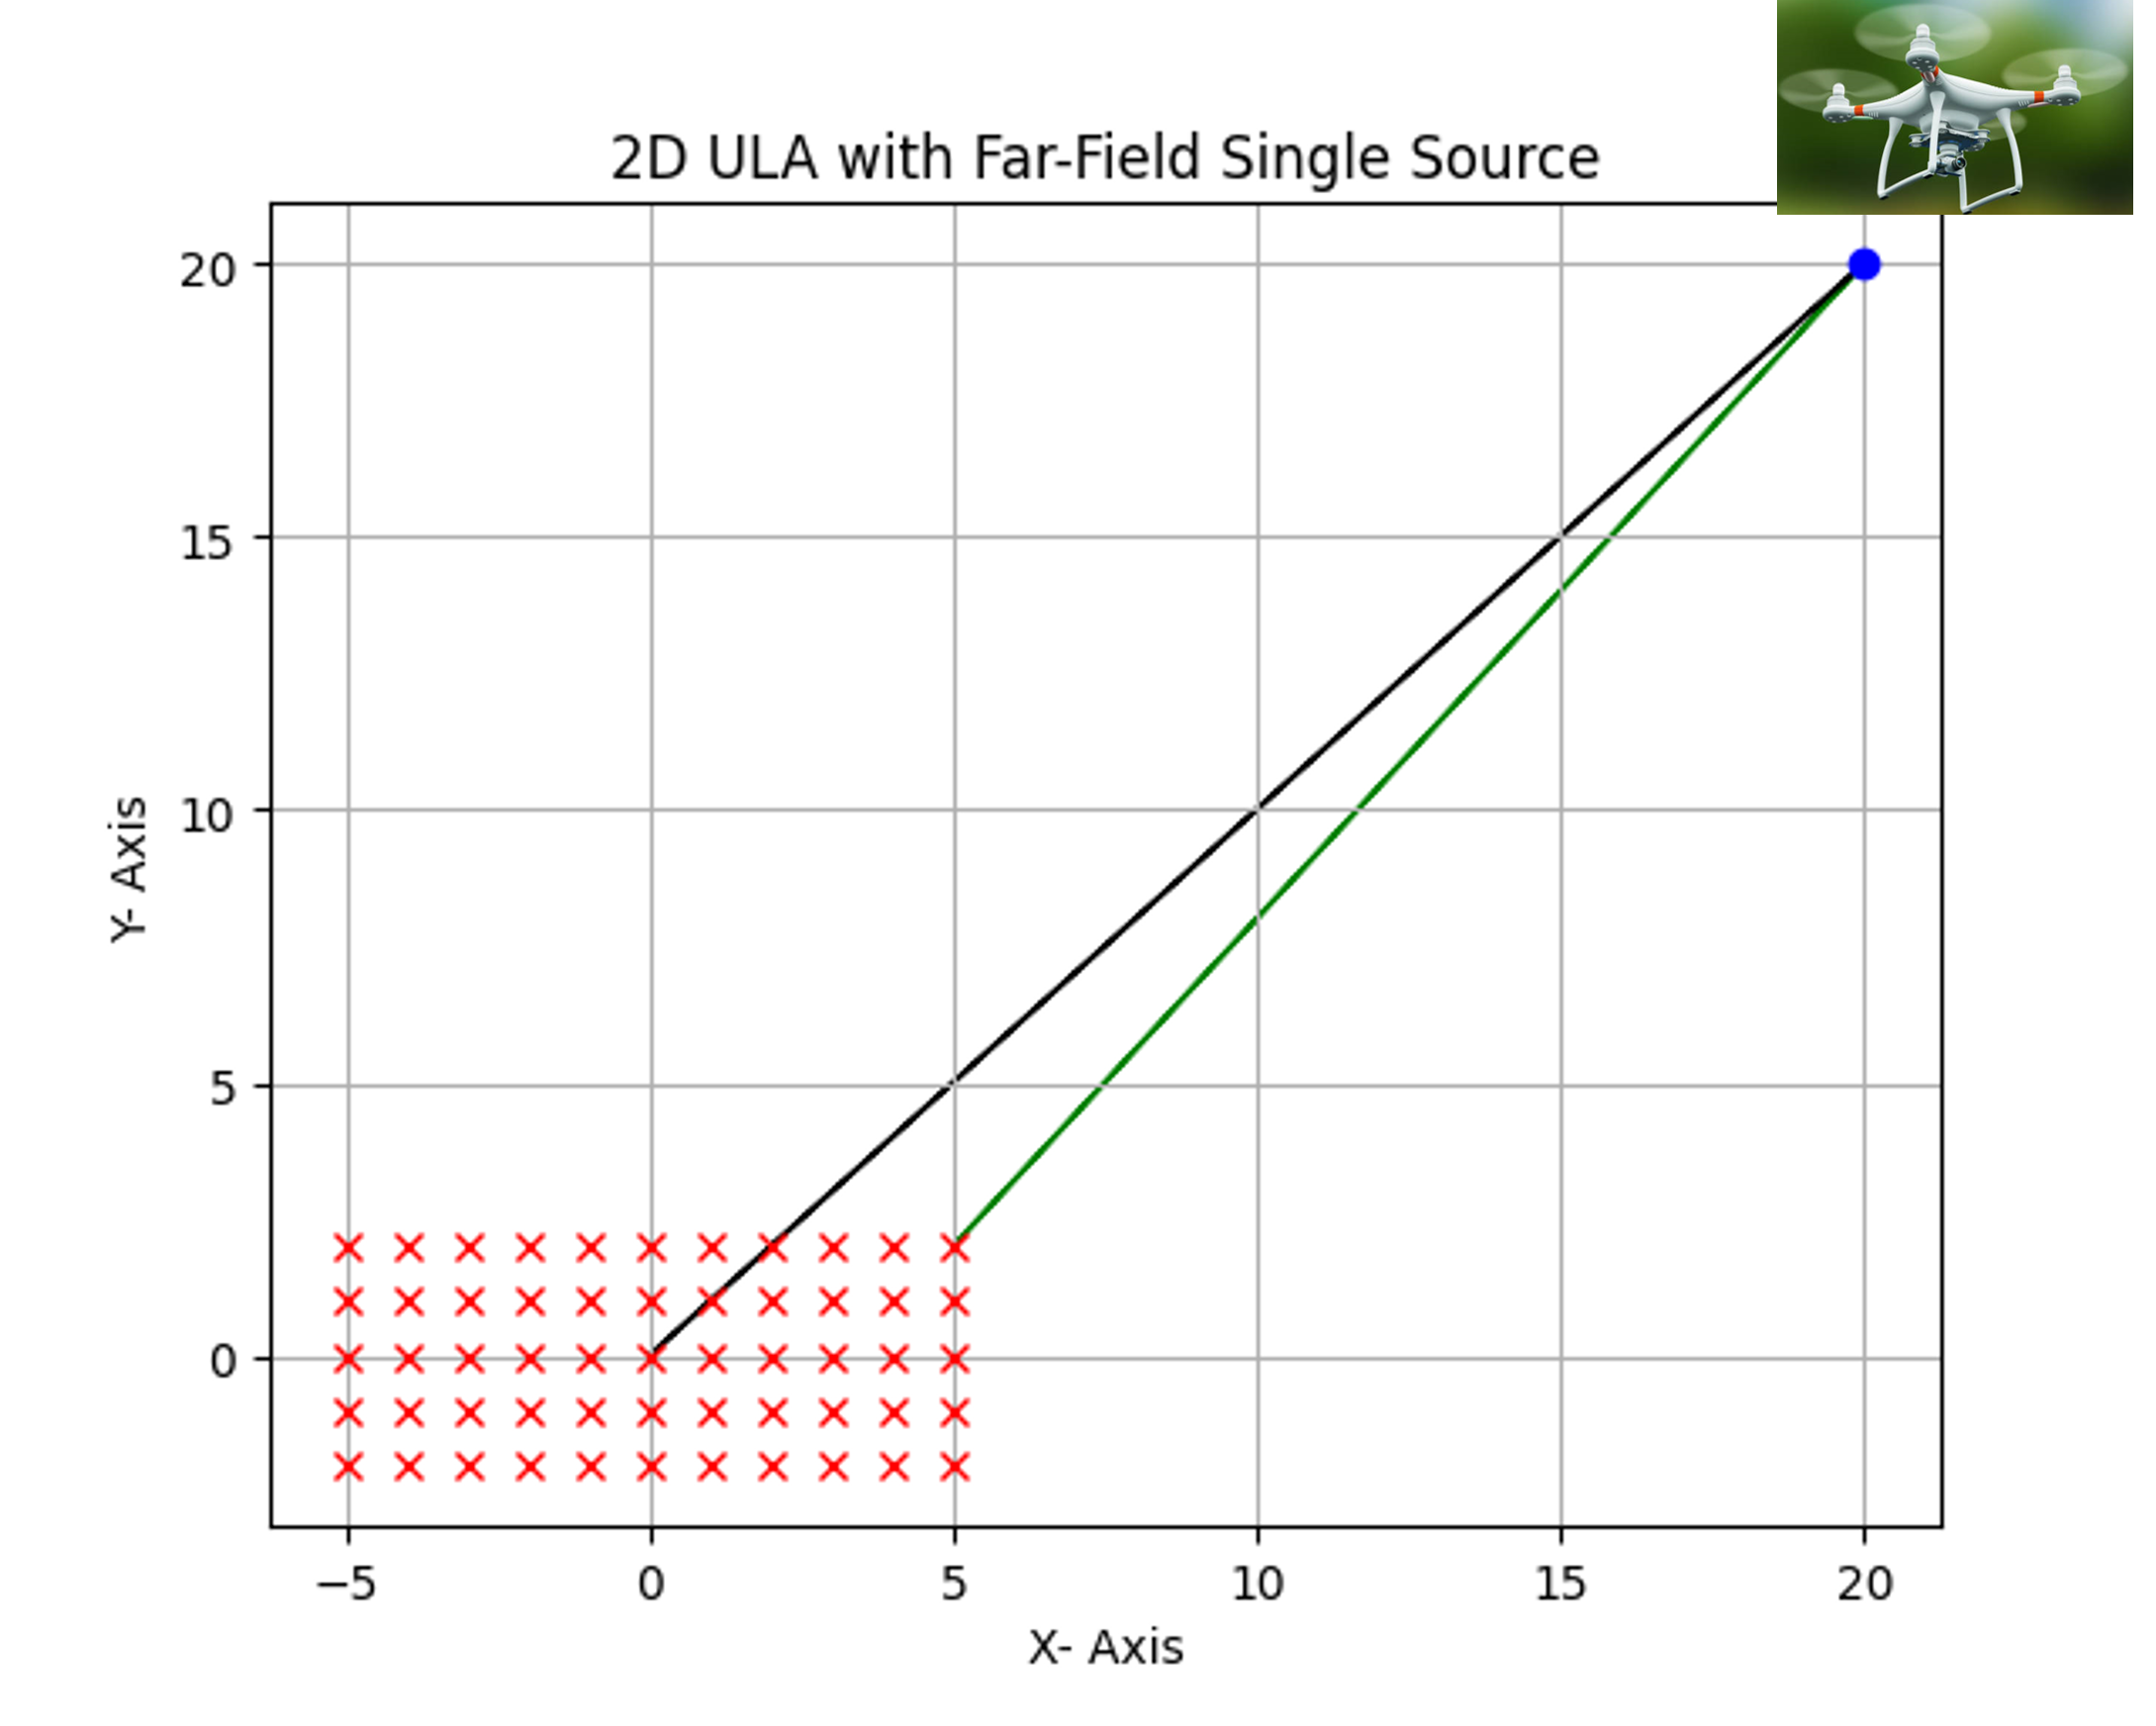

## System Model

Generate The System model:
1. Array of equally spaced N sensors
2. M radiates sources , coherent and non-ccoherent
3. narrow band of wide band model


Source Information lies in the difference between
the Source propagation delay at reference sensor
and at the n sensor

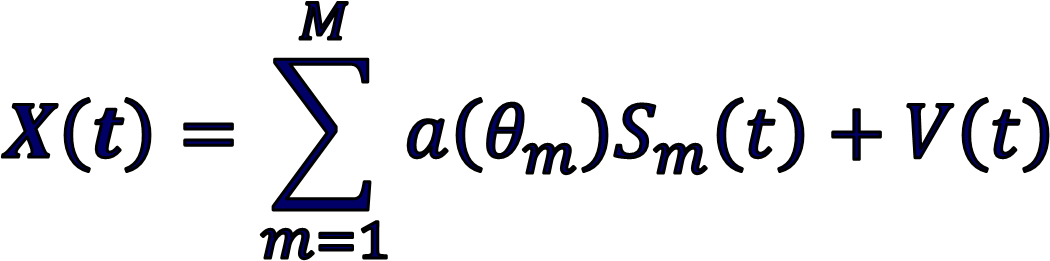

In [ ]:
class System_model(object):
    def __init__(self, scenario, N, M, DOA= None, freq_values = None):
        self.scenario = scenario                                    # Narrowband or Broadband
        self.N = N                                                  # Number of sensors in element
        self.M = M                                                  # Number of sources
        self.Scenario_define(freq_values)                           # Define parameters    
        self.Create_array()                                         # Define array indicies 
             
    def Scenario_define(self, freq_values):
        if self.scenario == "Broadband":
            ## frequencies initialization ##
            self.min_freq = freq_values[0]                          # Define minimal frequency value  
            self.max_freq = freq_values[1]                          # Define maximal frequency value  
            self.f_rng = np.linspace(start= self.min_freq,
                             stop= self.max_freq,
                              num= self.max_freq - self.min_freq,
                               endpoint = False)                    # Frequency range of interest  
            self.f_sampling = 2 * (self.max_freq)                   # Define sampling rate as twice the maximal frequency
            self.time_axis = np.linspace(0, 1, self.f_sampling,
                             endpoint = False)                      # Define time axis
            ## Array initialization ##
            self.dist = 1 / (2 * self.max_freq)                     # distance between array elements
        else: 
            ## frequencies initialization ##
            self.min_freq = None
            self.max_freq = None
            self.f_rng = None
            self.fs = None
            ## Array initialization ##
            self.dist = 1 / 2                                       # distance between array elements
 
    def Create_array(self):
        self.array = np.linspace(0, self.N, self.N, endpoint = False)   # create array of sensors locations
    
    def SV_Creation(self, theta, f = 1, Array_form = "ULA"):
        if self.scenario == "NarrowBand":
           f = 1
        if Array_form == "ULA":
            return np.exp(-2 * 1j * np.pi * f * self.dist * self.array * np.sin(theta))

    def __str__(self):
        print("System Model Summery:")
        for key,value in self.__dict__.items():
            print (key, " = " ,value)
        return "End of Model"

## Signals Creation

Creats the Observations model as following:

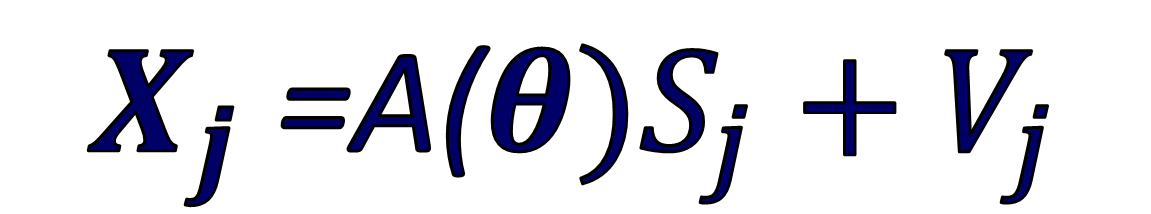

In [ ]:
def CreateDOAwithGapM(M, gap):
  while(True):
    DOA = np.round(np.random.rand(M) * 180 ,decimals=0) - 90
    DOA.sort()
    diffbetweenAngles = np.array([np.abs(DOA[i+1] - DOA[i]) for i in range(M-1)])
    if(np.sum(diffbetweenAngles > gap) == M - 1 and np.sum(diffbetweenAngles < (180 - gap)) == M - 1):
      break
  return DOA

class Sampels(object):
    def __init__(self, System_model, DOA, observations):
        self.scenario = System_model.scenario
        self.N = System_model.N
        self.M = System_model.M
        self.T = observations
        self.SV_Creation = System_model.SV_Creation
        if DOA == None:
          self.DOA = (np.pi / 180) * np.array(CreateDOAwithGapM(M = self.M, gap = 15)) # (~0.08 rad)
        else: 
          self.DOA = (np.pi / 180) * np.array(DOA)                              # define DOA angels
    
    
    def Sampels_creation(self, mode, N_mean= 0, N_Var= 1, S_mean= 0, S_Var= 1, SNR= 10, Carriers= None):
        '''
        @mode = represent the specific mode in the specific scnarion
                e.g. "Broadband" scenarion in "non-coherent" mode
        '''
        signal = self.Signal_creation(mode, S_mean, S_Var, SNR, Carriers)
        noise = self.Noise_Creation(N_mean, N_Var)
        A = np.array([self.SV_Creation(theta) for theta in self.DOA]).T
        
        if self.scenario == "NarrowBand":
            sampels = (A @ signal) + noise 
            return sampels, signal, A, noise

        elif self.scenario == "Broadband":
            self.time_axis = System_model.time_axis
            samples = []
            SV = []
            self.f_sampling = System_model.f_sampling

            freq_axis = np.sort(-1 * np.linspace(-self.f_sampling // 2, -self.f_sampling // 2 , -self.f_sampling, endpoint=False))
            for idx,f in enumerate(freq_axis):
                A = np.array([self.SV_Creation(theta,f) for theta in self.DOA]).T
                samples.append((A @ signal[:, idx]) + noise[:, idx])
                SV.append(A)
            samples = np.array(samples)
            SV = np.array(SV)
            sampels_time_domain = np.fft.ifft(samples.T, axis=1)[:, :self.T]
            return sampels_time_domain, signal, SV, noise

    def Noise_Creation(self, N_mean, N_Var):
        if self.scenario == "NarrowBand":
            # for NarrowBand scenario Noise represented in the time domain
            return np.sqrt(N_Var) * (np.random.randn(self.N, self.T) + 1j * np.random.randn(self.N, self.T)) + N_mean
        elif self.scenario == "Broadband":
            # for Broadband scenario Noise represented in the frequency domain
            noise = (np.sqrt(2) / 2) * (np.random.randn(self.N, len(self.time_axis)) + 1j * np.random.randn(self.N, len(self.time_axis))) + N_mean
            return np.fft.fft(noise)
    
    def Signal_creation(self, mode, S_mean=0, S_Var=1, SNR= 10, Carriers= None):
        if self.scenario == "NarrowBand":
            f = 1
            # Amp = 20 * np.log10(SNR)
            Amp = (10 ** (SNR / 10))

            if mode == "non-coherent": 
            # create M non - coherent signals
                # return Amp * np.sqrt(S_Var) * (np.random.randn(self.M, self.T) + 1j * np.random.randn(self.M, self.T)) + S_mean
                return Amp * np.ones((self.M, self.T))
        
            elif mode == "coherent": 
                # create coherent signal such that all signals are the same
                # and arrived from different angels
                sig = Amp * np.sqrt(S_Var) * (np.random.randn(1, self.T) + 1j * np.random.randn(1, self.T)) + S_mean
                return np.repeat(sig, self.M, axis = 0)
        
        if self.scenario == "Broadband":
            Amp = (np.sqrt(2) / 2 ) * 20 * np.log10(SNR) 
            # Amp = (10 ** (SNR / 10))
            sig = []
            if mode == "non-coherent":
                for f_c in Carriers:
                    Amp_f_c = Amp * (np.random.randn() + 1j * np.random.randn())
                    sig_fc = Amp_f_c * np.exp(2 * np.pi * 1j * f_c * self.time_axis)
                    sig.append(sig_fc)
                # for Broadband scenario Noise represented in the frequency domain
                return np.fft.fft(sig)
            ###### should be updated ######
            if mode == "OFDM": 
                pass
            if mode == "mod-OFDM": 
                pass
        else:
            return 0

## Model Based Bemformers

In [ ]:
class Model_Based_methods(object):
    def __init__(self,System_model):
        self.angels = np.linspace(-1 * np.pi / 2, np.pi / 2, 360, endpoint=False)                        # angle axis for representation of the MUSIC spectrum
        self.system_model = System_model
        self.dist = System_model.dist
        self.M = System_model.M
        self.dist = System_model.dist                                                  
    
    def DAS(self, X):
        
        '''
        Implamentation of the Delay and SUM algorithm
        in Narrowband scenario, without applying Spatial Smoothing

        Input:
        @ X = sampels vector shape : Nx1
        @ NUM_OF_SOURCES = indication flag for the knowladge of number of sources
        
        Output:
        @ 
        '''
        Response = self.DAS_ResponseCurve(X)
        return Response                                                 
    
    def DAS_ResponseCurve(self, X, f=1, Array_form="ULA"):
        Response_Curve = []
        since = time.time()
        X_DAS = X.detach().numpy()
        for angle in self.angels:
            a = self.system_model.SV_Creation(theta = angle, f= f, Array_form = Array_form).reshape((X_DAS.shape[0],1))
            X_shift = np.multiply(np.conj(a), X_DAS)
            R_eps = (X_shift @ np.conj(X_shift).T) / X_DAS.shape[0]
            W_opt = np.ones((X_shift.shape[0], 1))
            Response_Curve.append(np.asscalar((np.conj(W_opt).T @ R_eps @ W_opt).reshape((1))))
        Response_Curve = np.array(Response_Curve, dtype=np.complex)
        
        until = time.time() - since
        print('Operation of DAS completed in {:.0f}m {:.6f}s'.format( until // 60, until % 60))
        return Response_Curve 
    
    def SpatialSmoothEigenBased_MVDR(self, X, SubArraySize, eps):
        '''
        Implamentation of the Minimum Variance Beamformer algorithm
        in Narrowband scenario, while applying Spatial Smoothing

        Input:
        @ X = sampels vector shape : Nx1
        
        Output:
        @ 

        '''
        ## Spatial Smoothing Initialization
        X = np.array(X)
        X_observations = X
        NunberOfSensors = X_observations.shape[0]
        NumberOfSubArrays = NunberOfSensors - SubArraySize + 1
        Response_Curve = []
        since = time.time()
        for angle in self.angels:
            X_SubArrays = []
            Rx_SubArrays = []
            a = self.system_model.SV_Creation(theta = angle, f= 1, Array_form = "ULA").reshape((NunberOfSensors,1))
            X_shift = np.multiply(np.conj(a), X_observations)

            ## Empirical covariance estimation
            for j in range(NumberOfSubArrays):
                X_p = X_shift[j:j + SubArraySize]
                X_SubArrays.append(X_p)
                Rx_SubArrays.append((X_p @ np.conj(X_p).T) / SubArraySize)
            
            ## Avaraging covariance matrix
            Rx_SubArrays = np.array(Rx_SubArrays)
            Rx = Rx_SubArrays[0]
        
            for i in range(NumberOfSubArrays - 1):
                Rx += Rx_SubArrays[i + 1]
            Rx /= NumberOfSubArrays

            ## Avaraging Observations
            X_SubArrays = np.array(X_SubArrays)
            X_Avaraged = X_SubArrays[0]
        
            for i in range(NumberOfSubArrays - 1):
                X_Avaraged += X_SubArrays[i + 1]
            X_Avaraged /= NumberOfSubArrays

            
            ## Diagonal Loading
            R_eps_MVDR = Rx + eps * np.trace(Rx) * np.identity(Rx.shape[0])
        
            ## EigenValude Decomposition
            eigenvalues, eigenvectors = np.linalg.eig(R_eps_MVDR)
            eigenvalues = np.array(sorted(eigenvalues, reverse = True)).reshape(-1)
            M_est = np.sum(eigenvalues > 0.17)                  
        
            Us = eigenvectors[:, :M_est]

            ## BeamForming response calculation 
            Response_Curve = self.BF_ResponseCurveSmoothEigenBased(Response_Curve, R_eps_MVDR, SubArraySize, Us, X_Avaraged)
            
        Response_Curve = np.array(Response_Curve, dtype=np.complex)
        until = time.time() - since
        return Response_Curve                                                
    
    def BF_ResponseCurveSmoothEigenBased(self, Response_Curve, R_eps_MVDR, SubArraySize, Us, X_Avaraged):
        R_inv = np.linalg.inv(R_eps_MVDR)
        a = np.ones((SubArraySize,1))
        
        ## Adaptive calculation of W_opt
        W_opt = (R_inv @ a) / (np.conj(a).T @ R_inv @ a)
        
        ## Weights projection over the signal subspace
        W_opt = Us @ np.conj(Us).T @ W_opt

        # Response_Curve.append(np.asscalar((np.conj(W_opt).T @ X_Avaraged).reshape((1))))
        Response_Curve.append(np.asscalar((np.conj(W_opt).T @ R_eps_MVDR @ W_opt).reshape((1))))

        return Response_Curve
    def SpatialSmooth_MVDR(self, X, SubArraySize, eps):
        '''
        Implamentation of the Minimum Variance Beamformer algorithm
        in Narrowband scenario, while applying Spatial Smoothing

        Input:
        @ X = sampels vector shape : Nx1
        
        Output:
        @ 

        '''
        ## Spatial Smoothing Initialization
        until = 0
        X = np.array(X)
        X_observations = X
        NunberOfSensors = X_observations.shape[0]
        NumberOfSubArrays = NunberOfSensors - SubArraySize + 1
        Response_Curve = []
        since = time.time()
        for angle in self.angels:
            X_SubArrays = []
            Rx_SubArrays = []
            a = self.system_model.SV_Creation(theta = angle, f= 1, Array_form = "ULA").reshape((NunberOfSensors,1))
            X_shift = np.multiply(np.conj(a), X_observations)

            ## Empirical covariance estimation
            for j in range(NumberOfSubArrays):
                X_p = X_shift[j:j + SubArraySize]
                X_SubArrays.append(X_p)
                Rx_SubArrays.append((X_p @ np.conj(X_p).T) / SubArraySize)
            
            ## Avaraging covariance matrix
            Rx_SubArrays = np.array(Rx_SubArrays)
            Rx = Rx_SubArrays[0]
        
            for i in range(NumberOfSubArrays - 1):
                Rx += Rx_SubArrays[i + 1]
            Rx /= NumberOfSubArrays

            ## Avaraging Observations
            X_SubArrays = np.array(X_SubArrays)
            X_Avaraged = X_SubArrays[0]
        
            for i in range(NumberOfSubArrays - 1):
                X_Avaraged += X_SubArrays[i + 1]
            X_Avaraged /= NumberOfSubArrays

            
            ## Diagonal Loading
            R_eps_MVDR = Rx + eps * np.trace(Rx) * np.identity(Rx.shape[0])
        
            ## BeamForming response calculation 
            since = time.time()
            Response_Curve = self.BF_ResponseCurveSmooth(Response_Curve, R_eps_MVDR, SubArraySize)
            until += time.time() - since
            
        Response_Curve = np.array(Response_Curve, dtype=np.complex)
        print("MVDR elapsed: ", until)
        return Response_Curve                                                
    
    def BF_ResponseCurveSmooth(self, Response_Curve, R_eps_MVDR, SubArraySize):
        R_inv = np.linalg.inv(R_eps_MVDR)
        a = np.ones((SubArraySize,1))
        
        ## Adaptive calculation of W_opt
        W_opt = (R_inv @ a) / (np.conj(a).T @ R_inv @ a)
        
        # Response_Curve.append(np.asscalar((np.conj(W_opt).T @ X_Avaraged).reshape((1))))
        Response_Curve.append(np.asscalar((np.conj(W_opt).T @ R_eps_MVDR @ W_opt).reshape((1))))

        return Response_Curve

## Data Creation

Generates the Data Sampels for both the model based and the Deep Bemformer

In [ ]:
def CreateDataSet(scenario, mode, N, M, T, Sampels_size, SubArraySize, Save=False, DataSet_path= None, True_DOA = None, SNR = 10):
    '''
    @Scenario = "NarrowBand" or "BroadBand"
    @mode = "coherent", "non-coherent"
    '''
    
    # If comparing to EigenBased MVDR then True, for Basic MVDR flag = False
    EigenBasedFlag = False
    DataSet = []
    Sys_Model = System_model(scenario= scenario, N= N, M= M)                                    # System Model Initialization
    model_based_platform = Model_Based_methods(Sys_Model)
    for i in tqdm(range(Sampels_size)):
        Sys_Model_sampels = Sampels(Sys_Model, DOA= True_DOA, observations=1)                  # Sampels Creation - Model Initialization 
        X = Sys_Model_sampels.Sampels_creation(mode = mode, N_mean= 0,
                                                N_Var= 1, S_mean= 0, S_Var= 1,
                                                SNR= SNR, Carriers= None)[0]                   # Sampels Creation 
                                                
        if (EigenBasedFlag):
          EBMVDR_Response = model_based_platform.SpatialSmoothEigenBased_MVDR(X, SubArraySize = SubArraySize, eps = 0.001)
          Y = torch.tensor(EBMVDR_Response, dtype=torch.complex64)
        else:
          MVDR_Response = model_based_platform.SpatialSmooth_MVDR(X, SubArraySize = SubArraySize, eps = 0.001)
          Y = torch.tensor(MVDR_Response, dtype=torch.complex64)
        X = torch.tensor(X, dtype=torch.complex64)                                             # Sampels Creation
        for i, angle in enumerate(model_based_platform.angels):
            a = torch.tensor(Sys_Model.SV_Creation(theta = angle, f= 1, Array_form = "ULA"), dtype=torch.complex64).reshape((Sys_Model.N, 1))
            X_shift = torch.multiply(torch.conj(a), X)
            DataSet.append((X_shift,Y[i].reshape((1))))
            
    if Save:
        torch.save(obj= DataSet, f=DataSet_path + '\\DataSet_x_{}_{}_M={}_N={}_Sampels={}_Angels={}'.format(scenario, mode, M, N, Sampels_size, model_based_platform.angels.shape[0]) + '.h5')
        torch.save(obj= Sys_Model, f=DataSet_path + '\\Sys_Model_{}_{}_M={}_N={}_Sampels={}_Angels={}'.format(scenario, mode, M, N, Sampels_size, model_based_platform.angels.shape[0]) + '.h5')
    
    return DataSet ,Sys_Model

def Read_Data(Data_path):
    Data = torch.load(Data_path)
    return Data

In [ ]:
CreateData = True

if CreateData:
  Set_Overall_Seed()
  Create_Training_Data = True
  Create_Testing_Data = False

  ############################
  ###   Create Data Sets   ###
  ############################

  N = 256
  M = 1
  # For Constant Angle, M must be equal to number od angels set
  T = 1
  nNumberOfSampels = 1

  if Create_Training_Data:
    ## Training Datasets
    DataSet_x, Sys_Model = CreateDataSet(
                            scenario= "NarrowBand",
                            mode= "non-coherent",
                            N= N, M= M , T= 1,
                            Sampels_size = nNumberOfSampels,
                            SubArraySize = int(N / 4),
                            Save = True,
                            DataSet_path = Data_saving_path,
                            # for random creation of angles - True_DOA = None
                            # True_DOA = None,
                            # for constant Angels - True_DOA = [angle1, angle2, ...]
                            True_DOA = [0],
                            SNR = 10)
else:
  DataSet_x = Read_Data(Data_saving_path + r"\DataSet_x_NarrowBand_non-coherent_M=1_N=64_Sampels=2500_Angels=360.h5")
  Sys_Model = Read_Data(Data_saving_path + r"\Sys_Model_NarrowBand_non-coherent_M=1_N=64_Sampels=2500_Angels=360.h5")

## Models

### Complex ABLE

Both real ang Imag parts of observation are fed to Network, Dimension of ABLE are twicw bigger in comparison to the model presented in article

In [ ]:
class ABLE(nn.Module):
    def __init__(self, System_model):
        super(ABLE, self).__init__()
        self.system_model = System_model
        self.N = self.system_model.N
        # self.Cnnd1 = self.nn.Conv1d(2 * self.N, depth_2, kernel_size=2)
        self.fc1 = nn.Linear(2 * self.N, 2 * self.N)
        self.BatchNorm2N = nn.BatchNorm1d(2 * self.N)
        self.fc2 = nn.Linear(4 * self.N, int(self.N / 2))
        self.fc3 = nn.Linear(self.N, int(self.N / 2))
        self.BatchNormNdiv2 = nn.BatchNorm1d(int(self.N / 2))
        self.fc4 = nn.Linear(self.N, self.N * 2)
        self.fc5 = nn.Linear(self.N, self.N)
        self.DropOut = nn.Dropout(0.2)
        self.Relu = nn.ReLU()
        self.angels = np.linspace(-1 * np.pi / 2, np.pi / 2, 360, endpoint=False)                        # angle axis for represantation of the MUSIC spectrum

    def AntiRectifier(self, X):
      meu = torch.mean(X)
      norm_ava_X = (X - meu) / torch.linalg.norm(X - meu)
      return torch.cat((self.Relu(norm_ava_X), self.Relu(-norm_ava_X)),1)
  
    def ConvertToReal(self, X_shift):
        self.BATCH_SIZE = X_shift.shape[0]
        X_shift_List = []
        for bs in range(self.BATCH_SIZE):
            # Try to insert only the real valued X
            X_shift_List.append(torch.cat((torch.real(X_shift[bs]),torch.imag(X_shift[bs])), 0).to(torch.float))
        return torch.stack(X_shift_List, dim = 0)
    
    def CreateBeamResponse(self, W_opt, X_shift):
        SteeredResponse = []
        for bs in range(self.BATCH_SIZE):
            W_opt_conj = torch.conj(W_opt[bs]).T
            R_eps = (X_shift[bs] @ torch.conj(X_shift[bs]).T) / self.N
            # SteeredResponse.append((W_opt_conj @ X_shift[bs]).reshape((1)))
            SteeredResponse.append((W_opt_conj @ R_eps @ W_opt[bs]).reshape((1)))
        return torch.stack(SteeredResponse, dim = 0)
    
    def forward(self, X_shift):
        Response_Curve = []
        # Input shape of signal X(t): [Batch size, N, 1]
        # self.N = X_shift.shape[1]
        X = self.ConvertToReal(X_shift)
        
        # Input shape of signal X(t): [Batch size, 2N, 1]
        ## ABLE Archtecture
        W = self.fc1(X.reshape((X.shape[0], X.shape[1])))
        W = self.AntiRectifier(W)
        W = self.DropOut(W)
        W = self.DropOut(self.AntiRectifier(self.fc2(W)))
        W = self.DropOut(self.AntiRectifier(self.fc3(W)))
        
        # W_opt shape : [Batch size, 2N, 1]
        W_opt = self.fc4(W) 
        
        W_opt_real = W_opt[:,:self.N]                                                 
        W_opt_imag = W_opt[:,self.N:]                                               # Output shape [Batch size, N, N])  
        
        # W_opt shape [Batch size, N, 1])
        # maybr should take only real vallues
        W_opt = torch.complex(W_opt_real, W_opt_imag)
        
        SteeredResponse = self.CreateBeamResponse(W_opt, X_shift)
        return SteeredResponse, W_opt


### Real Valued Model

Only the Real part of observation is fed to Network, Dimension of ABLE are identical to the model presented in article

In [ ]:
class ABLE(nn.Module):
    def __init__(self, System_model):
        super(ABLE, self).__init__()
        self.system_model = System_model
        self.N = self.system_model.N
        self.fc1 = nn.Linear(self.N, self.N)
        self.BatchNorm2N = nn.BatchNorm1d(self.N)
        self.fc2 = nn.Linear(2 * self.N, int(self.N / 4))
        self.fc3 = nn.Linear(int(self.N / 2), int(self.N / 4))
        self.BatchNormNdiv2 = nn.BatchNorm1d(self.N)
        self.fc4 = nn.Linear(int(self.N / 2), self.N)
        # self.fc5 = nn.Linear(self.N, self.N)
        self.DropOut = nn.Dropout(0.2)
        self.Relu = nn.ReLU()
        self.angels = np.linspace(-1 * np.pi / 2, np.pi / 2, 360, endpoint=False)                        # angle axis for represantation of the MUSIC spectrum

    def AntiRectifier(self, X):
      meu = torch.mean(X,1).repeat(X.shape[1],1)
      norm_ava_X = (X - meu) / torch.linalg.norm(X - meu)
      return torch.cat((self.Relu(norm_ava_X), self.Relu(-norm_ava_X)),1)
  
    def ConvertToReal(self, X_shift):
        self.BATCH_SIZE = X_shift.shape[0]
        X_shift_List = []
        for bs in range(self.BATCH_SIZE):
            # Try to insert only the real valued X
            X_shift_List.append(torch.cat((torch.real(X_shift[bs]),torch.imag(X_shift[bs])), 0).to(torch.float))
        return torch.stack(X_shift_List, dim = 0)
    
    def CreateBeamResponse(self, W_opt, X_shift):
        SteeredResponse = []
        for bs in range(self.BATCH_SIZE):
            W_opt_conj = torch.conj(W_opt[bs]).T
            R_eps = (X_shift[bs] @ ((X_shift[bs]).T)) / self.N
            # SteeredResponse.append((W_opt_conj @ X_shift[bs]).reshape((1)))
            SteeredResponse.append((W_opt_conj @ R_eps @ W_opt[bs]).reshape((1)))
        return torch.stack(SteeredResponse, dim = 0)
    
    def forward(self, X_shift):
        # Input shape of signal X(t): [Batch size, N, 1]
        # self.N = X_shift.shape[1]
        # X = self.ConvertToReal(X_shift)
        self.BATCH_SIZE = X_shift.shape[0]
        X = torch.real(X_shift)
        
        # Input shape of signal X(t): [Batch size, 2N, 1]
        ## ABLE Archtecture
        W = self.fc1(X.reshape((X.shape[0], X.shape[1])))
        W = self.AntiRectifier(W)
        W = self.DropOut(W)
        W = self.DropOut(self.AntiRectifier(self.fc2(W)))
        W = self.DropOut(self.AntiRectifier(self.fc3(W)))
        
        # W_opt shape : [Batch size, 2N, 1]
        W_opt = self.fc4(W) 
        
        # W_opt_real = W_opt[:,:self.N]                                                 
        # W_opt_imag = W_opt[:,self.N:]                                               # Output shape [Batch size, N, N])  
        
        # W_opt shape [Batch size, N, 1])
        # maybr should take only real vallues
        # W_opt = torch.complex(W_opt_real, W_opt_imag)
        
        SteeredResponse = self.CreateBeamResponse(W_opt,X)
        return SteeredResponse, W_opt


### Complex To Real

Both real ang Imag parts of observation are fed to Network, Dimension of first layer is 2n -> N, istead of N -> N as presente in Article.

In [ ]:
class ABLE(nn.Module):
    def __init__(self, System_model):
        super(ABLE, self).__init__()
        self.system_model = System_model
        self.N = self.system_model.N

        self.fc1 = nn.Linear(2 * self.N, self.N)
        self.BatchNorm2N = nn.BatchNorm1d(self.N)
        self.fc2 = nn.Linear(2 * self.N, int(self.N / 4))
        self.fc3 = nn.Linear(int(self.N / 2), int(self.N / 4))
        self.BatchNormNdiv2 = nn.BatchNorm1d(self.N)
        self.fc4 = nn.Linear(int(self.N / 2), 2 * self.N)
        self.DropOut = nn.Dropout(0.5)
        self.Relu = nn.ReLU()
        self.angels = np.linspace(-1 * np.pi / 2, np.pi / 2, 360, endpoint=False)                        # angle axis for represantation of the MUSIC spectrum

    def AntiRectifier(self, X):
      meu = torch.mean(X,1).repeat(X.shape[1],1)
      norm_ava_X = (X - meu.T) / torch.linalg.norm(X - meu.T)
      return torch.cat((self.Relu(norm_ava_X), self.Relu(-norm_ava_X)),1)
  
    def ConvertToReal(self, X_shift):
        self.BATCH_SIZE = X_shift.shape[0]
        X_shift_List = []
        for bs in range(self.BATCH_SIZE):
            # Try to insert only the real valued X
            X_shift_List.append(torch.cat((torch.real(X_shift[bs]),torch.imag(X_shift[bs])), 0).to(torch.float))
        return torch.stack(X_shift_List, dim = 0)
    
    def CreateBeamResponse(self, W_opt, X_shift):
        SteeredResponse = []
        for bs in range(self.BATCH_SIZE):
            W_opt_conj = torch.conj(W_opt[bs]).T
            R_eps = (X_shift[bs] @ torch.conj(X_shift[bs]).T) / self.N
            # SteeredResponse.append((W_opt_conj @ X_shift[bs]).reshape((1)))
            SteeredResponse.append((W_opt_conj @ R_eps @ W_opt[bs]).reshape((1)))
        return torch.stack(SteeredResponse, dim = 0)
    
    def forward(self, X_shift):
        Response_Curve = []
        # Input shape of signal X(t): [Batch size, N, 1]
        # self.N = X_shift.shape[1]
        X = self.ConvertToReal(X_shift)
        # Input shape of signal X(t): [Batch size, 2N, 1]

        ## ABLE Archtecture
        W = self.fc1(X.reshape((X.shape[0], X.shape[1])))
        W = self.AntiRectifier(W)
        W = self.DropOut(W)
        W = self.DropOut(self.AntiRectifier(self.fc2(W)))
        W = self.DropOut(self.AntiRectifier(self.fc3(W)))
        
        # W_opt shape : [Batch size, 2N, 1]
        W_opt = self.fc4(W) 
        
        W_opt_real = W_opt[:,:self.N]                                                 
        W_opt_imag = W_opt[:,self.N:]                                               # Output shape [Batch size, N, N])  
        
        # W_opt shape [Batch size, N, 1])
        # maybe should take only real vallues
        W_opt = torch.complex(W_opt_real, W_opt_imag)
        
        SteeredResponse = self.CreateBeamResponse(W_opt, X_shift)
        return SteeredResponse, W_opt


## Run A Simulation

### Run Simulation Function

In [ ]:
def Run_Simulation(Model_Train_DataSet,
                    Model_Test_DataSet, N, optimizer_name, lr_val, Schedular,
                    weight_decay_val, step_size_val, gamma_val, num_epochs,
                    model_name,
                    Bsize,
                    Sys_Model,
                    checkpoint_optimizer_path = saving_path,
                    load_flag = False, loading_path = None,
                    Plot = True, DataSetModelBased = None,
                    Plot_Spectrum_flag = False,
                    wlp = 0.1):
  
    ## Set the seed for all available random operations
    Set_Overall_Seed()
    
    ## Current date and time
    print("\n--- New Simulation ---\n")
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    dt_string_for_save = now.strftime("%d_%m_%Y_%H_%M")
    print("date and time =", dt_string)

    ############################
    ### Model initialization ###
    ############################

    # Create a model from `Deep_Root_Net`
    model = ABLE(Sys_Model)                              
    
    # Load it to the specified device, either gpu or cpu
    model = model.to(device)                                   
    
    ## Loading available model
    if load_flag == True:
      if torch.cuda.is_available() == False:
        model.load_state_dict(torch.load(loading_path, map_location=torch.device('cpu')))
        print("CPU")
      else:
        model.load_state_dict(torch.load(loading_path))
      print("Loaded Succesfully")
    
    ## Create an optimizer 
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr_val,weight_decay=weight_decay_val)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr_val)
    elif optimizer_name == "SGD Momentum":
        optimizer = optim.SGD(model.parameters(), lr=lr_val, momentum=0.9)
    if Schedular:
        
        lr_decay = lr_scheduler.StepLR(optimizer, step_size=step_size_val, gamma=gamma_val)

    ## Loss criterion
    criterion = SMSLELoss()                                     
    # criterion = nn.MSELoss(reduction='sum')                                     # Periodic rmse loss
    
    ############################
    ###  Data Organization   ###
    ############################

    ## Split data into Train and Validation
    Train_DataSet, Valid_DataSet = train_test_split(Model_Train_DataSet, test_size=0.2, shuffle = False)
    print("Training DataSet size", len(Train_DataSet))
    print("Validation DataSet size", len(Valid_DataSet))

    ## Transform Training Datasets into DataLoader Object    
    Train_data = torch.utils.data.DataLoader(Train_DataSet,
                                    batch_size = Bsize,
                                    shuffle=False,
                                    drop_last=False)  
    Valid_data = torch.utils.data.DataLoader(Valid_DataSet,
                                    batch_size = Bsize,
                                    shuffle=False,
                                    drop_last=False)
    
    ## Transform Test Dataset into DataLoader Object
    # print("Test_DataSet", len(Model_Test_DataSet))
    Test_data = torch.utils.data.DataLoader(Model_Test_DataSet,
                                    batch_size = 1,
                                    shuffle=False,
                                    drop_last=False)
    
    ############################
    ###     Train Model      ###
    ############################

    ## Train using the "train_model" function
    model, loss_train_list, loss_valid_list = train_model(model, Train_data, Valid_data,
                 optimizer, criterion, epochs= num_epochs, model_name=model_name, scheduler=lr_decay,
                    checkpoint_path= saving_path + '\ckpt-{}.pk', wlp = wlp)
    
    ## Save model Best weights
    torch.save(model.state_dict(), saving_path + '//' +  model_name + dt_string_for_save)
    
    ############################
    ###    Evaluate Model    ###
    ############################
    print("\n--- Evaluating Stage ---\n")
    ## Plot learning and validation loss curves
    if True:
      plot_learning_curve(list(range(num_epochs)), loss_train_list, loss_valid_list)


    ############################
    ###   Beamformer Curve   ###
    ############################

    model_based_platform = Model_Based_methods(Sys_Model)
    P_ABLE = []
    P_MVDR = []
    model.eval()
    time_elapsed = 0
    # present results for Training Data
    for i, angle in enumerate(model_based_platform.angels):
        model_output = model(Model_Train_DataSet[i][0].reshape((1,int(Sys_Model.N),1)))[0]
        P_ABLE.append(model_output.detach().numpy())
        P_MVDR.append(Model_Train_DataSet[i][1].detach().numpy())
    plt.figure()
    
    P_MVDR = np.abs(np.array(P_MVDR));
    P_ABLE = np.abs(np.array(P_ABLE).reshape((360)));
    plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_MVDR/ np.max(P_MVDR)), label = "P_MVDR")
    plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_ABLE/ np.max(P_ABLE)), label = "P_ABLE")
    plt.legend(bbox_to_anchor=(1.00,0.5), loc="center left", borderaxespad=0)
    plt.show()
    
    P_ABLE = []
    P_MVDR = []
    model.eval()
    time_elapsed = 0
    # present results for Training Data
    for i, angle in enumerate(model_based_platform.angels):
        model_output = model(Model_Train_DataSet[i][0].reshape((1,int(Sys_Model.N),1)))[0]
        P_ABLE.append(model_output.detach().numpy())
        P_MVDR.append(Model_Train_DataSet[i + len(Train_DataSet) + 1][2].detach().numpy())
    plt.figure()
    P_MVDR = np.abs(np.array(P_MVDR));
    P_ABLE = np.abs(np.array(P_ABLE).reshape((360)));
    plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_MVDR/ np.max(P_MVDR)), label = "P_MVDR")
    plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_ABLE/ np.max(P_ABLE)), label = "P_ABLE")
    plt.legend(bbox_to_anchor=(1.00,0.5), loc="center left", borderaxespad=0)
    plt.show()
    # return model, loss_train_list, loss_valid_list, ABLE_loss
    return model, loss_train_list, loss_valid_list


### Model train

In [ ]:
def train_model(model, Train_data, Valid_data,
                 optimizer, criterion, epochs,
                 model_name, scheduler=None, checkpoint_path=None, wlp = 0.1):
    PRINT_WEIGHTS = False
    since = time.time()
    loss_train_list = []
    loss_valid_list = []
    min_valid_loss = np.inf
    print("\n---Start Training Stage ---\n")

    for epoch in tqdm(range(epochs)):
        ## Train the model for a specific epoch
        train_length = 0
        Overall_train_loss = 0.0
        model.train()
        model = model.to(device)
        for i, data in enumerate(Train_data):
            X,P_EBMVDR = data
            train_length += X.shape[0]
            X = Variable(X, requires_grad=True).to(device)
            P_EBMVDR = Variable(P_EBMVDR, requires_grad=True).to(device)
            
            ## Compute model Responsee predictions  
            model_parameters = model(X)
            P_ABLE, W_opt = model_parameters
            ## Compute training loss
            train_loss = criterion(W_opt, torch.abs(P_ABLE), torch.abs(P_EBMVDR), wlp = wlp)
            ## Backpropogation stage
    
            train_loss.backward()

            ## perform parameter update
            optimizer.step()                                                     
            
            ## nullify gradients
            model.zero_grad()

            # Add  batch training loss to epoch loss
            Overall_train_loss += train_loss.item()  

            # # print("iteration loss : ",train_loss.item())
            # if i % 1000 == 0:
            #   print("Iteration = {}, accumulated loss= {}".format(i+1, Overall_train_loss / train_length))
            
            ## Print Weightss
            if PRINT_WEIGHTS:
              for name, param in model.named_parameters():
                if param.grad is not None:
                  print(name, param.grad.sum())
                else:
                  print(name, param.grad)

        # print("len(Train_data)", len(Train_data))
        # print("Overall_train_loss = {}, train_length = {}".format(Overall_train_loss, train_length))
        Overall_train_loss = Overall_train_loss / train_length               # compute the epoch training loss
        loss_train_list.append(Overall_train_loss)
        if scheduler != None:
            scheduler.step()
        ## Evaluate the model for a specific epoch
        Overall_valid_loss = evaluate_model(model, Valid_data, criterion)
        loss_valid_list.append(Overall_valid_loss)
        
        ## Report results
        print("epoch : {}/{}, Train loss = {:.6f}, Validation loss = {:.6f}".format(epoch + 1,
                         epochs, Overall_train_loss, Overall_valid_loss))                       # display the epoch training loss
        print('lr {}'.format(optimizer.param_groups[0]['lr']))
        
        ## save model weights for better validation performences
        if min_valid_loss > Overall_valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{Overall_valid_loss:.6f}) \t Saving The Model')
            min_valid_loss = Overall_valid_loss
            best_epoch = epoch
            ## Saving State Dict
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), saving_path + '//' +  model_name)
    
    time_elapsed = time.time() - since
    # plot_learning_curve(list(range(epochs)),
    #                     loss_train_list, loss_valid_list)
    print("\n--- Training summary ---")
    print('Training complete in {:.0f}m {:.0f}s'.format( time_elapsed // 60, time_elapsed % 60))
    print('Minimal Validation loss: {:4f} at epoch {}'.format(min_valid_loss, best_epoch))

    # load best model weights
    model.load_state_dict(best_model_wts)
    # torch.save(model.state_dict(), saving_path + '//' +  model_name)
    return model, loss_train_list, loss_valid_list


### Model evaluate

In [ ]:
def evaluate_model(model, Data, criterion):
    loss = 0.0
    model.eval()
    data_length = 0
    with torch.no_grad():                                                                   
        for i, data in enumerate(Data):
            X, P_EBMVDR = data
            data_length += P_EBMVDR.shape[0]
            X = X.to(device)
            P_EBMVDR = P_EBMVDR.to(device)
            
            ## Compute model Responsee predictions  
            model_parameters = model(X)
            P_ABLE, W_opt = model_parameters
            
            ## Compute evaluation loss
            data_loss = criterion(W_opt, torch.abs(P_ABLE), torch.abs(P_EBMVDR))
            
            loss += data_loss.item()                                          # add the batch evaluation loss to epoch loss
        # print(len(Data))    
        loss = loss / data_length
    return loss

### Auxilary functions

In [ ]:
def plot_learning_curve(epoch_list, train_loss, Validation_loss):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Epoch")
    plt.plot(epoch_list, train_loss, label="Train")
    plt.plot(epoch_list, Validation_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Loss Criterion

In [ ]:
class SMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss(reduction='sum')
    def forward(self, weights, pred, actual,  wlp = 0.5):
        
        Normalized = True
        if (Normalized == True):
            pred = pred / torch.max(pred)
            actual = actual / torch.max(actual)
            Positive_loss = self.mse(20 * torch.log10(torch.max(0 * pred, pred).float()), 20 * torch.log10(torch.max(actual * 0, actual).float()))
        else:
            Positive_loss = self.mse(20 * torch.log10(torch.max(0 * pred, pred).float()), 20 * torch.log10(torch.max(actual * 0, actual).float()))
        for bs in range(weights.shape[0]):
            if bs == 0:                 
                Weight_loss = torch.abs((weights[bs] @ torch.ones_like(weights[0])) - 1)**2
            else:                 
                Weight_loss += torch.abs((weights[bs] @ torch.ones_like(weights[0])) - 1)**2
        return wlp * Positive_loss + (1- wlp) * Weight_loss

## Load Weights

In [ ]:
Loading_flag = False

if Loading_flag == True:
    model = ABLE(Sys_Model)                              
    # Load it to the specified device, either gpu or cpu
    model = model.to(device)                                   
    # evaluate_model(model, Va)
    ## Loading available model
    if torch.cuda.is_available() == False:
        model.load_state_dict(torch.load(r"C:\Users\dorsh\OneDrive\שולחן העבודה\Final Project\python notebooks\Weights\model_with_07_06_2022_21_48", map_location=torch.device('cpu')))
        print("CPU")
    else:
        model.load_state_dict(torch.load(r"C:\Users\dorsh\OneDrive\שולחן העבודה\Final Project\python notebooks\Weights\model05_06_2022_21_28"))
        print("Loaded Succesfully")



## Simulations

#### Angle = 0, 1000 sampels


--- New Simulation ---

date and time = 10/06/2022 16:16:35
CPU
Loaded Succesfully
Training DataSet size 144000
Validation DataSet size 36000

---Start Training Stage ---



  7%|▋         | 1/15 [01:45<24:37, 105.54s/it]

epoch : 1/15, Train loss = 2.052429, Validation loss = 13.867971
lr 0.0001
Validation Loss Decreased(inf--->13.867971) 	 Saving The Model


 13%|█▎        | 2/15 [03:29<22:42, 104.79s/it]

epoch : 2/15, Train loss = 1.460863, Validation loss = 13.717088
lr 0.0001
Validation Loss Decreased(13.867971--->13.717088) 	 Saving The Model


 20%|██        | 3/15 [05:12<20:47, 103.94s/it]

epoch : 3/15, Train loss = 1.504996, Validation loss = 13.603870
lr 0.0001
Validation Loss Decreased(13.717088--->13.603870) 	 Saving The Model


 27%|██▋       | 4/15 [06:57<19:07, 104.36s/it]

epoch : 4/15, Train loss = 1.326103, Validation loss = 13.644355
lr 0.0001


 33%|███▎      | 5/15 [08:42<17:23, 104.35s/it]

epoch : 5/15, Train loss = 1.301229, Validation loss = 13.254366
lr 0.0001
Validation Loss Decreased(13.603870--->13.254366) 	 Saving The Model


 40%|████      | 6/15 [10:25<15:37, 104.16s/it]

epoch : 6/15, Train loss = 1.355902, Validation loss = 13.315121
lr 0.0001


 47%|████▋     | 7/15 [12:10<13:54, 104.36s/it]

epoch : 7/15, Train loss = 1.372866, Validation loss = 13.194063
lr 0.0001
Validation Loss Decreased(13.254366--->13.194063) 	 Saving The Model


 53%|█████▎    | 8/15 [13:53<12:06, 103.81s/it]

epoch : 8/15, Train loss = 1.465538, Validation loss = 13.194892
lr 0.0001


 60%|██████    | 9/15 [15:36<10:21, 103.51s/it]

epoch : 9/15, Train loss = 1.465083, Validation loss = 12.854839
lr 0.0001
Validation Loss Decreased(13.194063--->12.854839) 	 Saving The Model


 67%|██████▋   | 10/15 [17:21<08:40, 104.02s/it]

epoch : 10/15, Train loss = 1.318202, Validation loss = 12.746298
lr 0.0001
Validation Loss Decreased(12.854839--->12.746298) 	 Saving The Model


 73%|███████▎  | 11/15 [19:05<06:56, 104.10s/it]

epoch : 11/15, Train loss = 1.391367, Validation loss = 12.761635
lr 0.0001


 80%|████████  | 12/15 [20:50<05:12, 104.25s/it]

epoch : 12/15, Train loss = 1.462522, Validation loss = 12.846215
lr 0.0001


 87%|████████▋ | 13/15 [22:34<03:28, 104.15s/it]

epoch : 13/15, Train loss = 1.444675, Validation loss = 12.794487
lr 0.0001


 93%|█████████▎| 14/15 [24:17<01:43, 103.83s/it]

epoch : 14/15, Train loss = 1.495998, Validation loss = 13.090662
lr 0.0001


100%|██████████| 15/15 [26:01<00:00, 104.12s/it]

epoch : 15/15, Train loss = 1.409167, Validation loss = 12.825715
lr 0.0001

--- Training summary ---
Training complete in 26m 2s
Minimal Validation loss: 12.746298 at epoch 9

--- Evaluating Stage ---



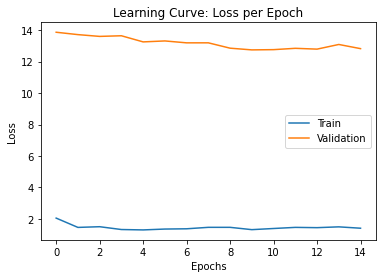

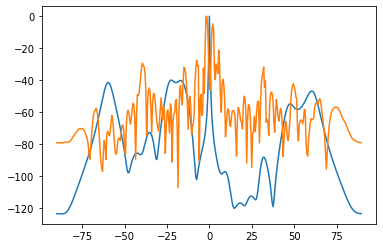

In [ ]:
model, loss_train_list, loss_valid_list = Run_Simulation(
                Model_Train_DataSet = DataSet_x,
                Model_Test_DataSet = None,
                N = Sys_Model.N,
                optimizer_name = "Adam",
                lr_val = 0.0001,
                Schedular = True,
                weight_decay_val = 1e-3,
                step_size_val = 60,
                gamma_val = 1,
                num_epochs = 15,
                model_name="model_100_Sampels",
                Bsize = 360,
                # Bsize = 256,
                Sys_Model = Sys_Model,
                load_flag = True,
                loading_path = r"/content/drive/Othercomputers/ה-מחשב נייד שלי/תואר שני/Model Based Deep Learning/Final Project/python notebooks/Weights/model_100_Sampels10_06_2022_15_14",
                Plot = False,
                DataSetModelBased = None)

### Comparing to MVDR

#### Weighted SMSLE wlp = 0.5


--- New Simulation ---

date and time = 14/06/2022 22:48:01
CPU
Loaded Succesfully
Training DataSet size 720000
Validation DataSet size 180000

---Start Training Stage ---



100%|██████████| 1/1 [06:28<00:00, 388.34s/it]

epoch : 1/1, Train loss = 0.040532, Validation loss = 2.703001
lr 1e-05
Validation Loss Decreased(inf--->2.703001) 	 Saving The Model

--- Training summary ---
Training complete in 6m 28s
Minimal Validation loss: 2.703001 at epoch 0

--- Evaluating Stage ---



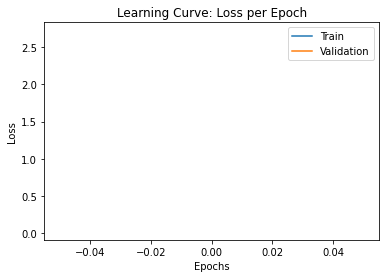

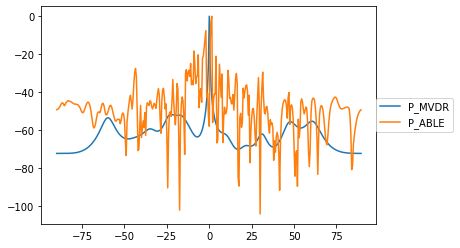

In [ ]:
# Complex To Real model
model, loss_train_list, loss_valid_list = Run_Simulation(
                Model_Train_DataSet = DataSet_x,
                Model_Test_DataSet = None,
                N = Sys_Model.N,
                optimizer_name = "Adam",
                lr_val = 0.00001,
                Schedular = True,
                weight_decay_val = 1e-3,
                step_size_val = 30,
                gamma_val = 0.1,
                num_epochs = 1,
                model_name="model_100_Sampels",
                Bsize = 360,
                # Bsize = 256,
                Sys_Model = Sys_Model,
                load_flag = True,
                loading_path = saving_path + r"/model_100_Sampels",
                Plot = False,
                DataSetModelBased = None,
                wlp = 0.5)

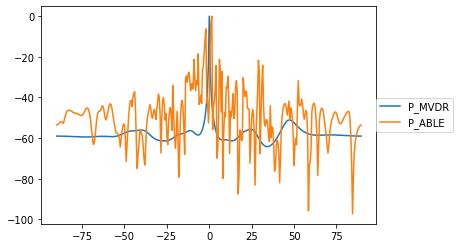

DOR


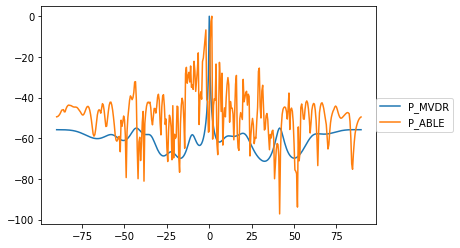

DOR


In [ ]:
model_based_platform = Model_Based_methods(Sys_Model)
P_ABLE = []
P_MVDR = []
model.eval()
for i, angle in enumerate(model_based_platform.angels):
    P_ABLE.append(model(DataSet_x[i + 1 * 360][0].reshape((1,Sys_Model.N,1)))[0].detach().numpy())
    P_MVDR.append(DataSet_x[i + 1 * 360][1].detach().numpy())

plt.figure()
P_MVDR = np.abs(np.array(P_MVDR));
P_ABLE = np.abs(np.array(P_ABLE).reshape((360)));
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_MVDR/ np.max(P_MVDR)), label = "P_MVDR")
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_ABLE/ np.max(P_ABLE)), label = "P_ABLE")
plt.legend(bbox_to_anchor=(1.00,0.5), loc="center left", borderaxespad=0)
plt.show()
print("DOR")

P_ABLE = []
P_MVDR = []
model.eval()
for i, angle in enumerate(model_based_platform.angels):
    P_ABLE.append(model(DataSet_x[i + 2 * 360][0].reshape((1,Sys_Model.N,1)))[0].detach().numpy())
    P_MVDR.append(DataSet_x[i + 2 * 360][1].detach().numpy())

plt.figure()
P_MVDR = np.abs(np.array(P_MVDR));
P_ABLE = np.abs(np.array(P_ABLE).reshape((360)));
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_MVDR/ np.max(P_MVDR)), label = "P_MVDR")
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_ABLE/ np.max(P_ABLE)), label = "P_ABLE")
plt.legend(bbox_to_anchor=(1.00,0.5), loc="center left", borderaxespad=0)
plt.show()
print("DOR")

#### wlp simulation

wlp = 0

--- New Simulation ---

date and time = 17/06/2022 01:10:19
Training DataSet size 28800
Validation DataSet size 7200

---Start Training Stage ---



100%|██████████| 30/30 [06:42<00:00, 13.41s/it]


--- Training summary ---
Training complete in 6m 42s
Minimal Validation loss: 1035.655543 at epoch 29

--- Evaluating Stage ---



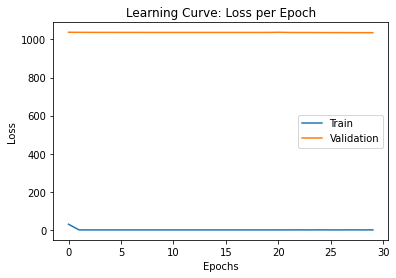

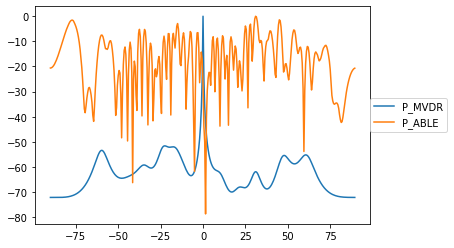

wlp = 0.2

--- New Simulation ---

date and time = 17/06/2022 01:17:02
Training DataSet size 28800
Validation DataSet size 7200

---Start Training Stage ---



100%|██████████| 30/30 [06:44<00:00, 13.47s/it]


--- Training summary ---
Training complete in 6m 44s
Minimal Validation loss: 21.240427 at epoch 29

--- Evaluating Stage ---



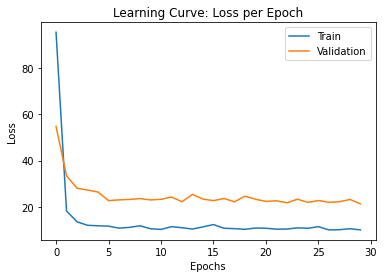

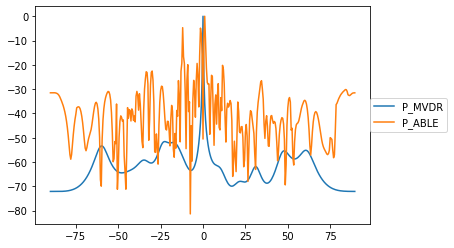

wlp = 0.4

--- New Simulation ---

date and time = 17/06/2022 01:23:46
Training DataSet size 28800
Validation DataSet size 7200

---Start Training Stage ---



100%|██████████| 30/30 [06:40<00:00, 13.35s/it]


--- Training summary ---
Training complete in 6m 40s
Minimal Validation loss: 21.139323 at epoch 26

--- Evaluating Stage ---



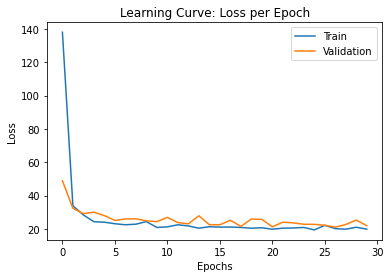

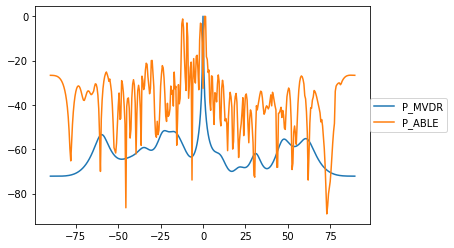

wlp = 0.6

--- New Simulation ---

date and time = 17/06/2022 01:30:26
Training DataSet size 28800
Validation DataSet size 7200

---Start Training Stage ---



100%|██████████| 30/30 [06:42<00:00, 13.41s/it]


--- Training summary ---
Training complete in 6m 42s
Minimal Validation loss: 22.541273 at epoch 15

--- Evaluating Stage ---



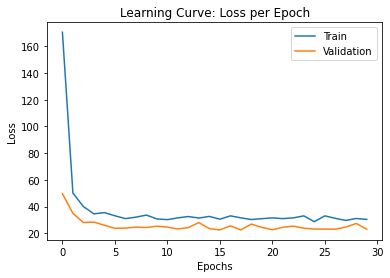

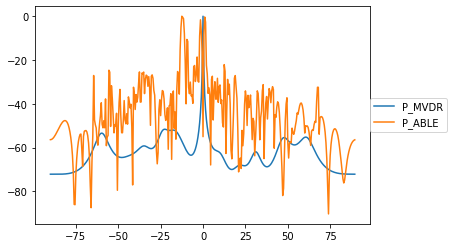

wlp = 0.8

--- New Simulation ---

date and time = 17/06/2022 01:37:09
Training DataSet size 28800
Validation DataSet size 7200

---Start Training Stage ---



100%|██████████| 30/30 [06:39<00:00, 13.32s/it]


--- Training summary ---
Training complete in 6m 40s
Minimal Validation loss: 22.107941 at epoch 26

--- Evaluating Stage ---



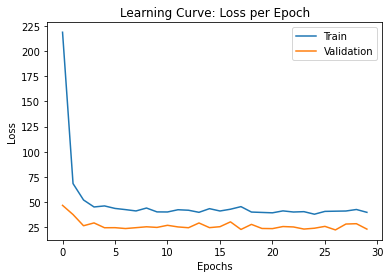

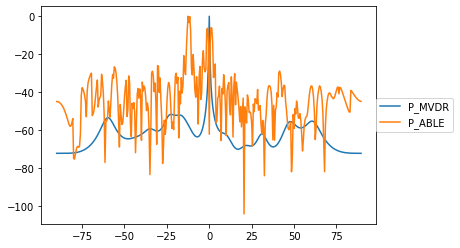

wlp = 0.95

--- New Simulation ---

date and time = 17/06/2022 01:43:49
Training DataSet size 28800
Validation DataSet size 7200

---Start Training Stage ---



100%|██████████| 30/30 [06:38<00:00, 13.29s/it]


--- Training summary ---
Training complete in 6m 39s
Minimal Validation loss: 30.266061 at epoch 29

--- Evaluating Stage ---



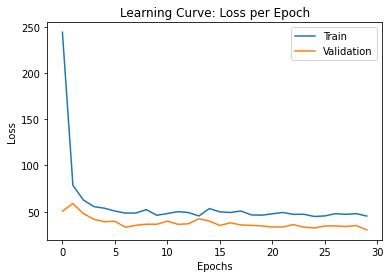

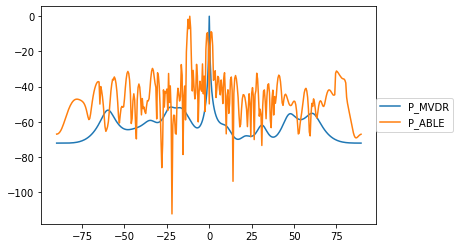

wlp = 1

--- New Simulation ---

date and time = 17/06/2022 01:50:28
Training DataSet size 28800
Validation DataSet size 7200

---Start Training Stage ---



100%|██████████| 30/30 [07:08<00:00, 14.27s/it]


--- Training summary ---
Training complete in 7m 8s
Minimal Validation loss: 909.763025 at epoch 0

--- Evaluating Stage ---



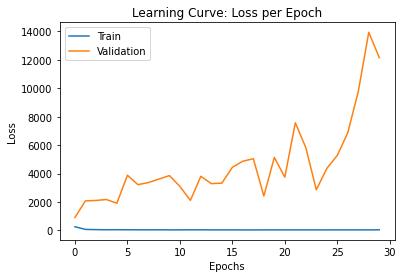

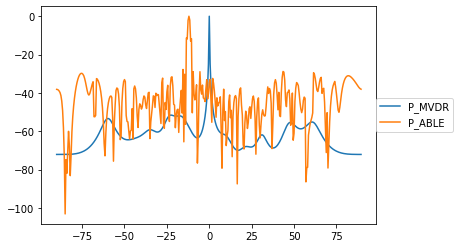

In [ ]:
# Complex To Real model
for wlp_val in [0, 0.2, 0.4, 0.6 ,0.8 ,0.95, 1]:
                print("wlp = {}".format(wlp_val))
                model, loss_train_list, loss_valid_list = Run_Simulation(
                                Model_Train_DataSet = DataSet_x,
                                Model_Test_DataSet = None,
                                N = Sys_Model.N,
                                optimizer_name = "Adam",
                                lr_val = 0.01,
                                Schedular = True,
                                weight_decay_val = 1e-9,
                                step_size_val = 30,
                                gamma_val = 1,
                                num_epochs = 30,
                                model_name="model_100_Sampels",
                                Bsize = 360,
                                Sys_Model = Sys_Model,
                                load_flag = False,
                                loading_path = saving_path + r"/model_100_Sampels",
                                Plot = False,
                                DataSetModelBased = None,
                                wlp = wlp_val)

#### 2500 samples, wd = 1e-9, wlp = 0.6


--- New Simulation ---

date and time = 17/06/2022 12:16:10
Training DataSet size 288000
Validation DataSet size 72000

---Start Training Stage ---



  3%|▎         | 1/30 [05:16<2:33:05, 316.73s/it]

epoch : 1/30, Train loss = 134.066491, Validation loss = 23.313803
lr 0.001
Validation Loss Decreased(inf--->23.313803) 	 Saving The Model


  7%|▋         | 2/30 [10:34<2:28:00, 317.16s/it]

epoch : 2/30, Train loss = 29.275455, Validation loss = 21.048894
lr 0.001
Validation Loss Decreased(23.313803--->21.048894) 	 Saving The Model


 10%|█         | 3/30 [15:40<2:20:32, 312.33s/it]

epoch : 3/30, Train loss = 26.962743, Validation loss = 19.155152
lr 0.001
Validation Loss Decreased(21.048894--->19.155152) 	 Saving The Model


 13%|█▎        | 4/30 [20:57<2:16:06, 314.11s/it]

epoch : 4/30, Train loss = 26.261721, Validation loss = 18.686282
lr 0.001
Validation Loss Decreased(19.155152--->18.686282) 	 Saving The Model


 17%|█▋        | 5/30 [26:07<2:10:18, 312.74s/it]

epoch : 5/30, Train loss = 25.469063, Validation loss = 18.435780
lr 0.001
Validation Loss Decreased(18.686282--->18.435780) 	 Saving The Model


 20%|██        | 6/30 [30:53<2:01:20, 303.36s/it]

epoch : 6/30, Train loss = 25.589216, Validation loss = 18.682932
lr 0.001


 23%|██▎       | 7/30 [35:27<1:52:40, 293.95s/it]

epoch : 7/30, Train loss = 25.165458, Validation loss = 19.176899
lr 0.001


 27%|██▋       | 8/30 [39:48<1:43:55, 283.43s/it]

epoch : 8/30, Train loss = 25.231842, Validation loss = 18.779208
lr 0.001


 30%|███       | 9/30 [42:28<1:25:41, 244.83s/it]

epoch : 9/30, Train loss = 24.824540, Validation loss = 18.097030
lr 0.001
Validation Loss Decreased(18.435780--->18.097030) 	 Saving The Model


 33%|███▎      | 10/30 [44:59<1:11:56, 215.82s/it]

epoch : 10/30, Train loss = 24.460162, Validation loss = 18.738641
lr 0.001


 37%|███▋      | 11/30 [47:32<1:02:17, 196.73s/it]

epoch : 11/30, Train loss = 23.983160, Validation loss = 17.837012
lr 0.001
Validation Loss Decreased(18.097030--->17.837012) 	 Saving The Model


 40%|████      | 12/30 [50:05<54:57, 183.21s/it]  

epoch : 12/30, Train loss = 23.438093, Validation loss = 19.094043
lr 0.001


 43%|████▎     | 13/30 [52:38<49:23, 174.32s/it]

epoch : 13/30, Train loss = 22.297749, Validation loss = 21.246112
lr 0.001


 47%|████▋     | 14/30 [55:09<44:36, 167.27s/it]

epoch : 14/30, Train loss = 22.188619, Validation loss = 21.160302
lr 0.001


 50%|█████     | 15/30 [57:40<40:35, 162.34s/it]

epoch : 15/30, Train loss = 22.177843, Validation loss = 20.758592
lr 0.001


 53%|█████▎    | 16/30 [1:00:13<37:12, 159.44s/it]

epoch : 16/30, Train loss = 21.970915, Validation loss = 19.959371
lr 0.001


 57%|█████▋    | 17/30 [1:02:44<33:59, 156.92s/it]

epoch : 17/30, Train loss = 22.279237, Validation loss = 20.965820
lr 0.001


 60%|██████    | 18/30 [1:05:15<31:01, 155.16s/it]

epoch : 18/30, Train loss = 22.238468, Validation loss = 21.143514
lr 0.001


 63%|██████▎   | 19/30 [1:07:46<28:12, 153.88s/it]

epoch : 19/30, Train loss = 21.875879, Validation loss = 21.171457
lr 0.001


 67%|██████▋   | 20/30 [1:10:18<25:33, 153.39s/it]

epoch : 20/30, Train loss = 21.704865, Validation loss = 21.458048
lr 0.001


 70%|███████   | 21/30 [1:15:01<28:49, 192.17s/it]

epoch : 21/30, Train loss = 21.725742, Validation loss = 20.126010
lr 0.001


 73%|███████▎  | 22/30 [1:20:59<32:16, 242.01s/it]

epoch : 22/30, Train loss = 21.555636, Validation loss = 21.803369
lr 0.001


 77%|███████▋  | 23/30 [1:26:45<31:51, 273.08s/it]

epoch : 23/30, Train loss = 21.505300, Validation loss = 18.841709
lr 0.001


 80%|████████  | 24/30 [1:32:55<30:13, 302.28s/it]

epoch : 24/30, Train loss = 21.392033, Validation loss = 20.439245
lr 0.001


 83%|████████▎ | 25/30 [1:37:40<24:45, 297.08s/it]

epoch : 25/30, Train loss = 21.521536, Validation loss = 20.044010
lr 0.001


 87%|████████▋ | 26/30 [1:40:49<17:38, 264.69s/it]

epoch : 26/30, Train loss = 21.157833, Validation loss = 19.392896
lr 0.001


 90%|█████████ | 27/30 [1:46:42<14:33, 291.16s/it]

epoch : 27/30, Train loss = 21.082715, Validation loss = 21.203998
lr 0.001


 93%|█████████▎| 28/30 [1:52:56<10:31, 315.89s/it]

epoch : 28/30, Train loss = 21.002756, Validation loss = 22.694378
lr 0.001


 97%|█████████▋| 29/30 [1:58:51<05:27, 327.84s/it]

epoch : 29/30, Train loss = 21.184123, Validation loss = 19.148675
lr 0.001


100%|██████████| 30/30 [2:01:44<00:00, 243.49s/it]

epoch : 30/30, Train loss = 20.874596, Validation loss = 19.070157
lr 0.0001

--- Training summary ---
Training complete in 121m 45s
Minimal Validation loss: 17.837012 at epoch 10

--- Evaluating Stage ---



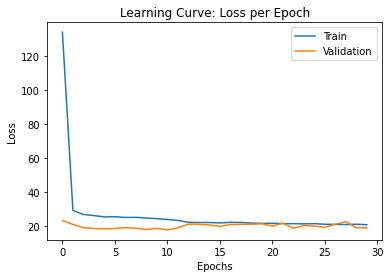

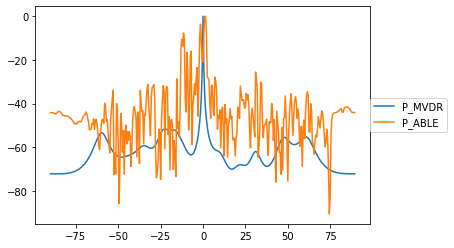

In [ ]:
# Complex To Real model - 1000 sampels
model, loss_train_list, loss_valid_list = Run_Simulation(
                Model_Train_DataSet = DataSet_x,
                Model_Test_DataSet = None,
                N = Sys_Model.N,
                optimizer_name = "Adam",
                lr_val = 0.001,
                Schedular = True,
                weight_decay_val = 1e-9,
                step_size_val = 30,
                gamma_val = 0.1,
                num_epochs = 30,
                model_name="model_100_Sampels",
                Bsize = 360,
                Sys_Model = Sys_Model,
                load_flag = False,
                loading_path = saving_path + r"/model_100_Sampels",
                Plot = False,
                DataSetModelBased = None,
                wlp = 0.6)

#### 2500 samples, wd = 1e-9, wlp = 0.99


--- New Simulation ---

date and time = 18/06/2022 00:33:15
Training DataSet size 720000
Validation DataSet size 180000

---Start Training Stage ---



  3%|▎         | 1/30 [06:32<3:09:41, 392.47s/it]

epoch : 1/30, Train loss = 93.932519, Validation loss = 88.979259
lr 0.001
Validation Loss Decreased(inf--->88.979259) 	 Saving The Model


  7%|▋         | 2/30 [13:07<3:03:50, 393.95s/it]

epoch : 2/30, Train loss = 39.854842, Validation loss = 85.287410
lr 0.001
Validation Loss Decreased(88.979259--->85.287410) 	 Saving The Model


 10%|█         | 3/30 [19:43<2:57:37, 394.72s/it]

epoch : 3/30, Train loss = 39.327567, Validation loss = 71.859613
lr 0.001
Validation Loss Decreased(85.287410--->71.859613) 	 Saving The Model


 13%|█▎        | 4/30 [26:18<2:51:07, 394.89s/it]

epoch : 4/30, Train loss = 38.024962, Validation loss = 63.992922
lr 0.001
Validation Loss Decreased(71.859613--->63.992922) 	 Saving The Model


 17%|█▋        | 5/30 [32:52<2:44:22, 394.49s/it]

epoch : 5/30, Train loss = 37.679805, Validation loss = 55.710416
lr 0.001
Validation Loss Decreased(63.992922--->55.710416) 	 Saving The Model


 20%|██        | 6/30 [39:25<2:37:40, 394.19s/it]

epoch : 6/30, Train loss = 36.576167, Validation loss = 44.603664
lr 0.001
Validation Loss Decreased(55.710416--->44.603664) 	 Saving The Model


 23%|██▎       | 7/30 [45:53<2:30:19, 392.13s/it]

epoch : 7/30, Train loss = 33.776993, Validation loss = 39.262388
lr 0.001
Validation Loss Decreased(44.603664--->39.262388) 	 Saving The Model


 27%|██▋       | 8/30 [52:21<2:23:15, 390.70s/it]

epoch : 8/30, Train loss = 32.820677, Validation loss = 38.755163
lr 0.001
Validation Loss Decreased(39.262388--->38.755163) 	 Saving The Model


 30%|███       | 9/30 [58:59<2:17:34, 393.06s/it]

epoch : 9/30, Train loss = 32.463734, Validation loss = 38.075045
lr 0.001
Validation Loss Decreased(38.755163--->38.075045) 	 Saving The Model


 33%|███▎      | 10/30 [1:05:36<2:11:23, 394.17s/it]

epoch : 10/30, Train loss = 32.406132, Validation loss = 43.292458
lr 0.001


 37%|███▋      | 11/30 [1:12:11<2:04:58, 394.68s/it]

epoch : 11/30, Train loss = 31.604604, Validation loss = 45.924880
lr 0.001


 40%|████      | 12/30 [1:18:45<1:58:17, 394.29s/it]

epoch : 12/30, Train loss = 31.198487, Validation loss = 47.540651
lr 0.001


 43%|████▎     | 13/30 [1:25:21<1:51:52, 394.83s/it]

epoch : 13/30, Train loss = 30.422200, Validation loss = 49.759298
lr 0.001


 47%|████▋     | 14/30 [1:31:54<1:45:07, 394.21s/it]

epoch : 14/30, Train loss = 30.071991, Validation loss = 46.125122
lr 0.001


 50%|█████     | 15/30 [1:38:27<1:38:27, 393.86s/it]

epoch : 15/30, Train loss = 29.396071, Validation loss = 43.871722
lr 0.001


 53%|█████▎    | 16/30 [1:45:00<1:31:53, 393.79s/it]

epoch : 16/30, Train loss = 28.523095, Validation loss = 39.031069
lr 0.001


 57%|█████▋    | 17/30 [1:51:34<1:25:20, 393.89s/it]

epoch : 17/30, Train loss = 27.818111, Validation loss = 58.297828
lr 0.001


 60%|██████    | 18/30 [1:58:09<1:18:48, 394.01s/it]

epoch : 18/30, Train loss = 26.877207, Validation loss = 39.519404
lr 0.001


 63%|██████▎   | 19/30 [2:04:44<1:12:18, 394.44s/it]

epoch : 19/30, Train loss = 26.809689, Validation loss = 50.890946
lr 0.001


 67%|██████▋   | 20/30 [2:11:18<1:05:43, 394.34s/it]

epoch : 20/30, Train loss = 26.326488, Validation loss = 46.501424
lr 0.001


 70%|███████   | 21/30 [2:17:55<59:15, 395.01s/it]  

epoch : 21/30, Train loss = 26.202183, Validation loss = 46.074919
lr 0.001


 73%|███████▎  | 22/30 [2:24:33<52:47, 395.92s/it]

epoch : 22/30, Train loss = 26.344889, Validation loss = 43.407670
lr 0.001


 77%|███████▋  | 23/30 [2:31:07<46:07, 395.35s/it]

epoch : 23/30, Train loss = 25.377920, Validation loss = 42.085314
lr 0.001


 80%|████████  | 24/30 [2:37:45<39:37, 396.31s/it]

epoch : 24/30, Train loss = 25.243207, Validation loss = 42.657499
lr 0.001


 83%|████████▎ | 25/30 [2:44:23<33:02, 396.58s/it]

epoch : 25/30, Train loss = 25.121313, Validation loss = 38.083514
lr 0.001


 87%|████████▋ | 26/30 [2:51:01<26:28, 397.16s/it]

epoch : 26/30, Train loss = 24.845539, Validation loss = 47.153922
lr 0.001


 90%|█████████ | 27/30 [2:57:44<19:56, 398.76s/it]

epoch : 27/30, Train loss = 24.788190, Validation loss = 53.965604
lr 0.001


 93%|█████████▎| 28/30 [3:04:15<13:13, 396.65s/it]

epoch : 28/30, Train loss = 24.538895, Validation loss = 48.975934
lr 0.001


 97%|█████████▋| 29/30 [3:10:52<06:36, 396.59s/it]

epoch : 29/30, Train loss = 24.130057, Validation loss = 45.153395
lr 0.001


100%|██████████| 30/30 [3:17:25<00:00, 394.87s/it]

epoch : 30/30, Train loss = 24.253078, Validation loss = 38.895015
lr 0.0001

--- Training summary ---
Training complete in 197m 26s
Minimal Validation loss: 38.075045 at epoch 8

--- Evaluating Stage ---



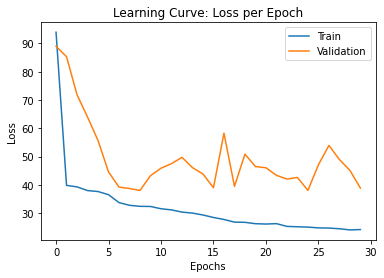

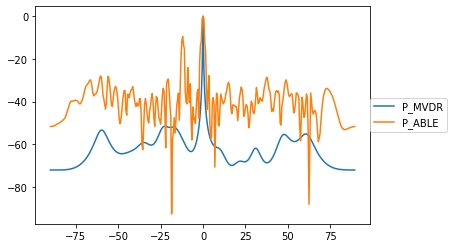

In [ ]:
# Complex To Real model - 2500 sampels
model, loss_train_list, loss_valid_list = Run_Simulation(
                Model_Train_DataSet = DataSet_x,
                Model_Test_DataSet = None,
                N = Sys_Model.N,
                optimizer_name = "Adam",
                lr_val = 0.001,
                Schedular = True,
                weight_decay_val = 1e-5,
                step_size_val = 30,
                gamma_val = 0.1,
                num_epochs = 30,
                model_name="model_100_Sampels",
                Bsize = 360,
                Sys_Model = Sys_Model,
                load_flag = False,
                loading_path = saving_path + r"/model_100_Sampels",
                Plot = False,
                DataSetModelBased = None,
                wlp = 0.99)

CPU


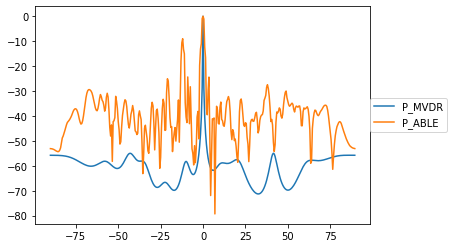

DOR


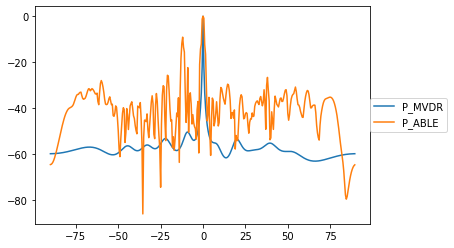

DOR


In [ ]:
Loading_flag = True

if Loading_flag == True:
    model = ABLE(Sys_Model)                              
    # Load it to the specified device, either gpu or cpu
    model = model.to(device)                                   
    # evaluate_model(model, Va)
    ## Loading available model
    if torch.cuda.is_available() == False:
        model.load_state_dict(torch.load(r"C:\Users\dorsh\OneDrive\שולחן העבודה\Final Project\python notebooks\Weights\model_100_Sampels18_06_2022_00_33", map_location=torch.device('cpu')))
        print("CPU")
    else:
        model.load_state_dict(torch.load(r"C:\Users\dorsh\OneDrive\שולחן העבודה\Final Project\python notebooks\Weights\model05_06_2022_21_28"))
        print("Loaded Succesfully")



model_based_platform = Model_Based_methods(Sys_Model)
P_ABLE = []
P_MVDR = []
model.eval()
for i, angle in enumerate(model_based_platform.angels):
    P_ABLE.append(model(DataSet_x[i + 2 * 360][0].reshape((1,Sys_Model.N,1)))[0].detach().numpy())
    P_MVDR.append(DataSet_x[i + 2 * 360][1].detach().numpy())

plt.figure()
P_MVDR = np.abs(np.array(P_MVDR));
P_ABLE = np.abs(np.array(P_ABLE).reshape((360)));
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_MVDR/ np.max(P_MVDR)), label = "P_MVDR")
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_ABLE/ np.max(P_ABLE)), label = "P_ABLE")
plt.legend(bbox_to_anchor=(1.00,0.5), loc="center left", borderaxespad=0)
plt.show()
print("DOR")

P_ABLE = []
P_MVDR = []
model.eval()
for i, angle in enumerate(model_based_platform.angels):
    P_ABLE.append(model(DataSet_x[i + 3 * 360][0].reshape((1,Sys_Model.N,1)))[0].detach().numpy())
    P_MVDR.append(DataSet_x[i + 3 * 360][1].detach().numpy())

plt.figure()
P_MVDR = np.abs(np.array(P_MVDR));
P_ABLE = np.abs(np.array(P_ABLE).reshape((360)));
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_MVDR/ np.max(P_MVDR)), label = "P_MVDR")
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_ABLE/ np.max(P_ABLE)), label = "P_ABLE")
plt.legend(bbox_to_anchor=(1.00,0.5), loc="center left", borderaxespad=0)
plt.show()
print("DOR")

CPU


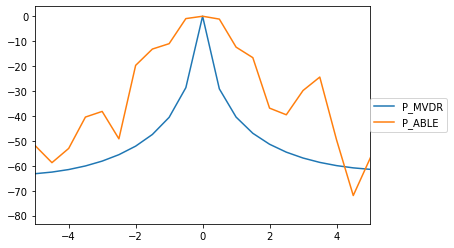

DOR
0.11118912696838379


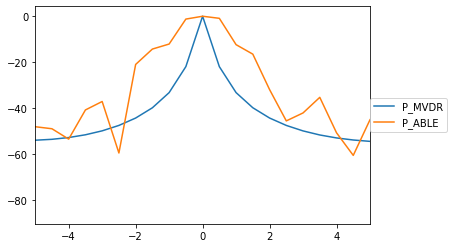

DOR


In [ ]:
Loading_flag = True

if Loading_flag == True:
    model = ABLE(Sys_Model)                              
    # Load it to the specified device, either gpu or cpu
    model = model.to(device)                                   
    ## Loading available model
    if torch.cuda.is_available() == False:
        model.load_state_dict(torch.load(r"C:\Users\dorsh\OneDrive\שולחן העבודה\Final Project\python notebooks\Weights\model_100_Sampels18_06_2022_00_33", map_location=torch.device('cpu')))
        print("CPU")
    else:
        model.load_state_dict(torch.load(r"C:\Users\dorsh\OneDrive\שולחן העבודה\Final Project\python notebooks\Weights\model05_06_2022_21_28"))
        print("Loaded Succesfully")



model_based_platform = Model_Based_methods(Sys_Model)
P_ABLE = []
P_MVDR = []
model.eval()
for i, angle in enumerate(model_based_platform.angels):
    P_ABLE.append(model(DataSet_x[i + 2 * 360][0].reshape((1,Sys_Model.N,1)))[0].detach().numpy())
    P_MVDR.append(DataSet_x[i + 2 * 360][1].detach().numpy())

plt.figure()
P_MVDR = np.abs(np.array(P_MVDR));
P_ABLE = np.abs(np.array(P_ABLE).reshape((360)));
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_MVDR/ np.max(P_MVDR)), label = "P_MVDR")
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_ABLE/ np.max(P_ABLE)), label = "P_ABLE")
plt.legend(bbox_to_anchor=(1.00,0.5), loc="center left", borderaxespad=0)
plt.xlim([-5,5])
plt.ylim([-60,0])
plt.show()
print("DOR")

P_ABLE = []
P_MVDR = []
model.eval()
until = 0
for i, angle in enumerate(model_based_platform.angels):
    Input_data = DataSet_x[i + 3 * 360][0].reshape((1,Sys_Model.N,1))
    since = time.time()
    model_output = model(Input_data)[0]
    until += time.time() - since
    P_ABLE.append(model_output.detach().numpy())
    P_MVDR.append(DataSet_x[i + 3 * 360][1].detach().numpy())

print(until)
plt.figure()
P_MVDR = np.abs(np.array(P_MVDR));
P_ABLE = np.abs(np.array(P_ABLE).reshape((360)));
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_MVDR/ np.max(P_MVDR)), label = "P_MVDR")
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_ABLE/ np.max(P_ABLE)), label = "P_ABLE")
plt.legend(bbox_to_anchor=(1.00,0.5), loc="center left", borderaxespad=0)
plt.xlim([-5,5])
plt.ylim([-60,0])
plt.show()
print("DOR")

ABLE aims **not to directly** improve the performances of the exist closed form solution, but to produce **DNN augmented algorithm** which **significantly** reduce the **computational burden** and performs just as well as the MVDR



### Time calculation

#### ABLE time calculation

In [ ]:
N = 64
model = ABLE(Sys_Model)                              
# Load it to the specified device, either gpu or cpu
model = model.to(device)
until = 0
for i, angle in enumerate(model_based_platform.angels):
    Input_data = DataSet_x[i ][0].reshape((1,Sys_Model.N,1))
    since = time.time()
    model_output = model(Input_data)[0]
    until += time.time() - since
print(until)

0.1262829303741455


#### MVDR time calculation

In [ ]:
DataSet_x, Sys_Model = CreateDataSet(
                scenario= "NarrowBand",
                mode= "non-coherent",
                N= 256, M= 1 , T= 1,
                Sampels_size = nNumberOfSampels,
                SubArraySize = 64,
                Save = True,
                DataSet_path = Data_saving_path,
                # for random creation of angles - True_DOA = None
                # True_DOA = None,
                # for constant Angels - True_DOA = [angle1, angle2, ...]
                True_DOA = [0],
                SNR = 10)

100%|██████████| 1/1 [00:11<00:00, 11.74s/it]

MVDR elapsed:  7.0910046100616455


**Time difference**:

MVDR / ABLE: 7.091 / 0.126 = 56.2 ~ N

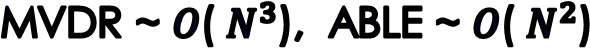

#### 5000 Sampels

CPU


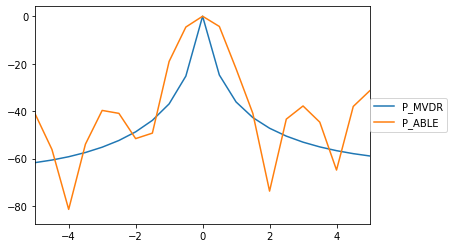

DOR
0.11890769004821777


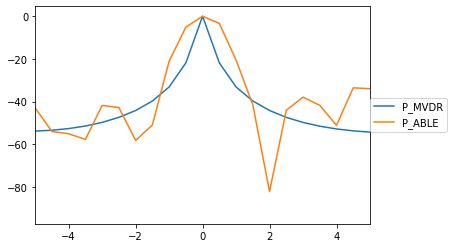

DOR


In [ ]:
Loading_flag = True

if Loading_flag == True:
    model = ABLE(Sys_Model)                              
    # Load it to the specified device, either gpu or cpu
    model = model.to(device)                                   
    # evaluate_model(model, Va)
    ## Loading available model
    if torch.cuda.is_available() == False:
        model.load_state_dict(torch.load(r"C:\Users\dorsh\OneDrive\שולחן העבודה\Final Project\python notebooks\Weights\model_5000_Sampels", map_location=torch.device('cpu')))
        print("CPU")
    else:
        model.load_state_dict(torch.load(r"C:\Users\dorsh\OneDrive\שולחן העבודה\Final Project\python notebooks\Weights\model05_06_2022_21_28"))
        print("Loaded Succesfully")



model_based_platform = Model_Based_methods(Sys_Model)
P_ABLE = []
P_MVDR = []
model.eval()
for i, angle in enumerate(model_based_platform.angels):
    P_ABLE.append(model(DataSet_x[i + 0 * 360][0].reshape((1,Sys_Model.N,1)))[0].detach().numpy())
    P_MVDR.append(DataSet_x[i + 0 * 360][1].detach().numpy())

plt.figure()
P_MVDR = np.abs(np.array(P_MVDR));
P_ABLE = np.abs(np.array(P_ABLE).reshape((360)));
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_MVDR/ np.max(P_MVDR)), label = "P_MVDR")
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_ABLE/ np.max(P_ABLE)), label = "P_ABLE")
plt.legend(bbox_to_anchor=(1.00,0.5), loc="center left", borderaxespad=0)
plt.xlim([-5,5])
plt.show()
print("DOR")

P_ABLE = []
P_MVDR = []
model.eval()
until = 0
for i, angle in enumerate(model_based_platform.angels):
    Input_data = DataSet_x[i + 3 * 360][0].reshape((1,Sys_Model.N,1))
    since = time.time()
    model_output = model(Input_data)[0]
    until += time.time() - since
    P_ABLE.append(model_output.detach().numpy())
    P_MVDR.append(DataSet_x[i + 3 * 360][1].detach().numpy())

print(until)
plt.figure()
P_MVDR = np.abs(np.array(P_MVDR));
P_ABLE = np.abs(np.array(P_ABLE).reshape((360)));
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_MVDR/ np.max(P_MVDR)), label = "P_MVDR")
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_ABLE/ np.max(P_ABLE)), label = "P_ABLE")
plt.legend(bbox_to_anchor=(1.00,0.5), loc="center left", borderaxespad=0)
plt.xlim([-5,5])
plt.show()
print("DOR")

#### Comparison to other "short-time" Beamformers

CPU


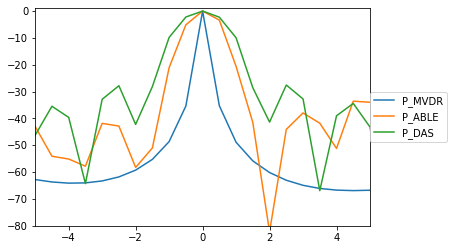

DOR


In [ ]:
Loading_flag = True

if Loading_flag == True:
    model = ABLE(Sys_Model)                              
    # Load it to the specified device, either gpu or cpu
    model = model.to(device)                                   
    # evaluate_model(model, Va)
    ## Loading available model
    if torch.cuda.is_available() == False:
        model.load_state_dict(torch.load(r"C:\Users\dorsh\OneDrive\שולחן העבודה\Final Project\python notebooks\Weights\model_1_Sampels", map_location=torch.device('cpu')))
        print("CPU")
    else:
        model.load_state_dict(torch.load(r"C:\Users\dorsh\OneDrive\שולחן העבודה\Final Project\python notebooks\Weights\model05_06_2022_21_28"))
        print("Loaded Succesfully")



model_based_platform = Model_Based_methods(Sys_Model)
P_ABLE = []
P_MVDR = []
P_DAS = []
model.eval()
for i, angle in enumerate(model_based_platform.angels):
    P_ABLE.append(model(DataSet_x[i + 3 * 360][0].reshape((1,Sys_Model.N,1)))[0].detach().numpy())
    P_MVDR.append(DataSet_x[i + 3 * 360][1].detach().numpy())
    P_DAS.append(DataSet_x[i + 3 * 360][2].detach().numpy())

plt.figure()
P_MVDR = np.abs(np.array(P_MVDR));
P_ABLE = np.abs(np.array(P_ABLE).reshape((360)));
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_MVDR/ np.max(P_MVDR)), label = "P_MVDR")
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_ABLE/ np.max(P_ABLE)), label = "P_ABLE")
plt.plot(model_based_platform.angels *180 / np.pi, 20 * np.log10(P_DAS/ np.max(P_DAS)), label = "P_DAS")
plt.legend(bbox_to_anchor=(1.00,0.5), loc="center left", borderaxespad=0)
plt.xlim([-5,5])
plt.ylim([-80,1])
plt.show()
print("DOR")